In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imb_Pipeline
import functions as F

## Load dataset

In [2]:
aave_loan_balance = pd.read_csv('./data/aave_loan_balance.csv')
application_previous = pd.read_csv('./data/application_previous.csv')
defi_credits = pd.read_csv('./data/defi_credits.csv')
defi_credits_balance = pd.read_csv('./data/defi_credits_balance.csv')
loan_application = pd.read_csv('./data/loan_application.csv')
payments_history = pd.read_csv('./data/payments_history.csv')

In [3]:
lst = [aave_loan_balance, application_previous, defi_credits, defi_credits_balance, loan_application, payments_history]

## EDA

#### primary_key

In [4]:
for i, data in enumerate(lst):
    print(f'{i}th table', end='\t')
    F.has_pk(data)

0th table	pk is not found
1th table	primary_key: application_id_previous
2th table	primary_key: defi_id
3th table	pk is not found
4th table	primary_key: application_id_current
5th table	pk is not found


#### null

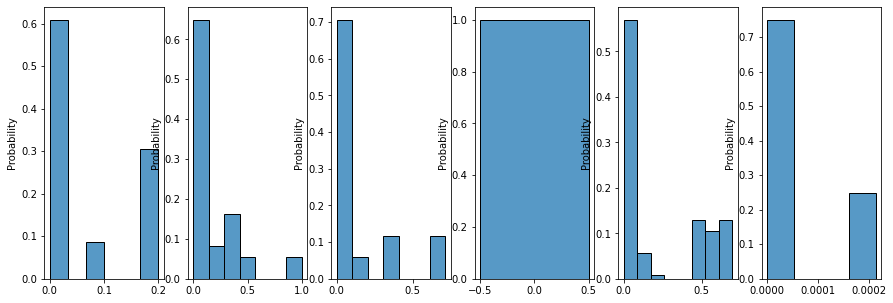

In [5]:
fig, axes = plt.subplots(1, 6, figsize=(15, 5))

for i, data in enumerate(lst):
    sns.histplot(F.check_null_status(data), ax=axes[i], stat='probability')

## Data preparation

#### loan_application (1/6)

In [6]:
loan_application.set_index('application_id_current', inplace=True)

In [7]:
prep_loan_application = loan_application.copy()
categorical_features = F.search_categoric(loan_application)

for col in categorical_features:
    prep_loan_application[col] = prep_loan_application[col].astype('object')

#### defi_credits (2/6) & defi_credits_balance (3/6)

In [8]:
temp = pd.pivot_table(data=defi_credits_balance,
                      index='defi_id',
                      columns='months_balance',
                      values='status')

In [9]:
prep_defi_credits_balance = temp.apply(np.nanmean, axis=1)
prep_defi_credits_balance.name = 'mean_balance'

In [10]:
defi_merged = pd.merge(defi_credits, 
                       prep_defi_credits_balance, 
                       how='left', 
                       left_on='defi_id', 
                       right_index=True)

In [11]:
prep_defi = F.aggregate(defi_merged, 
                        primary_key=['application_id_current'],
                        drop_cols=['defi_id'])

#### aave_loan_balance (4/6)

In [12]:
prep_aave_loan_balance = F.aggregate(aave_loan_balance,
                                     primary_key=['application_id_current'],
                                     drop_cols=['application_id_previous'])

#### application_previous (5/6)

In [13]:
application_previous = pd.read_csv('./data/application_previous.csv')

In [14]:
categorical_features = F.search_categoric(application_previous, cardinality_limit=10)

for col in categorical_features:
    application_previous[col] = application_previous[col].astype('object')

In [15]:
prep_application_previous = F.aggregate(application_previous,
                                        primary_key=['application_id_current'],
                                        drop_cols=['application_id_previous'])

#### payments_history (6/6)

In [16]:
payments_history['days_diff'] = payments_history['days_entry_payment'] - payments_history['days_instalment']

In [17]:
prep_payments_history = F.aggregate(payments_history,
                                    primary_key=['application_id_current'],
                                    drop_cols=['application_id_previous'])

## Merge datasets

In [18]:
preprocessed = [prep_loan_application, prep_aave_loan_balance, prep_application_previous, prep_defi, prep_payments_history]

for i, table in enumerate(preprocessed):
    print(f'{i} th table index : {table.index.name}')
    if i == 0:
        merged = prep_loan_application.copy()
    else:
        merged = pd.merge(merged, table, how='left', left_index=True, right_index=True)

0 th table index : application_id_current
1 th table index : application_id_current
2 th table index : application_id_current
3 th table index : application_id_current
4 th table index : application_id_current


## Split

In [19]:
cond = merged.type == 1
train_val = merged.loc[cond]
test = merged.loc[~cond]

X = train_val.drop('target', axis=1)
y = train_val.target.astype(str)

## Define a pipeline

In [20]:
numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selector(dtype_exclude="object")),
        ('cat', categorical_transformer, selector(dtype_include="object"))
    ])

In [21]:
model = lgb.LGBMClassifier(n_estimators=100)

In [22]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

In [23]:
params = {'classifier__learning_rate': [0.01, 0.05, 0.1],
          'classifier__num_leaves': [3, 6, 9],
          'classifier__reg_alpha': [1e-1, 1, 10]
         }

## Hyperparameter tuning

In [24]:
tuner = RandomizedSearchCV(
    estimator=clf,
    param_distributions=params,
    n_iter=3,
    scoring='roc_auc',
    cv=3,
    refit=True,
    verbose=True,
    n_jobs=-1
)

In [25]:
tuner.fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               MinMaxScaler(),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x00000217A87319A0>),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x00000217A6A73790>)])),
                                             ('classifier', LGBMClassifier())]),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'classifier__learning_rat

In [30]:
print(f'Best auroc: {tuner.best_score_:.4f}')

Best auroc: 0.7668


## Prediction

In [31]:
result = pd.Series(
    tuner.predict_proba(test.drop('target', axis=1))[:, 1],
    name='target',
    index=test.index)

In [32]:
result.to_csv('./Result.csv')